## Cohort Analysis Using a Fictional Customer Dataset - Karn Gill

Below is a fictional dataset obtained from the UCI Machine Learning Repository. I will be using this dataset to expand on my interest in the field of behavioural analytics by performing a cohort analysis. Cohort analysis is a powerful tool that can provide us with many important insights relating to customer trends through the segmentation of customer data into time-dependent categories. 

With the following fictional dataset, I will perform analysis for the years 2020 and 2021. 

### Methodology & Results

I will begin by importing the necessary libraries to perform the analysis. 

In [265]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from operator import attrgetter

Reading in the necessary excel file

In [266]:


data = pd.read_excel('/Users/karn/Desktop/EDA/Online Retail.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Upon first glance, we can see that there is a noticeable difference between the values in the CustomerID field when compared to the other fields. 

Before beginning analysis, one of the most important considerations for any analyst to make is how to deal with NULL values. In this case, we have approximately 135,000 records absent from the CustomerID field, however given the sheer size of the dataset, we can safely assume that there will not be a susbtantial impact on the findings if these records were excluded. I will simply drop the records containing NULL values and proceed.  

In [267]:
data = data.dropna()
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Now that the null values have been dropped I can begin some exploratory data analysis to gain a better understanding of my data. 

In [268]:
avg_price = data['UnitPrice'].mean()
avg_price

3.4604710185298773

Here we can see that the average unit price of each product is approximately $3.46

In [269]:
most_common = data['Description'].value_counts()
most_common

WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
                                      ... 
ANTIQUE RASPBERRY FLOWER EARRINGS        1
WALL ART,ONLY ONE PERSON                 1
GOLD/AMBER DROP EARRINGS W LEAF          1
INCENSE BAZAAR PEACH                     1
PINK BAROQUE FLOCK CANDLE HOLDER         1
Name: Description, Length: 3896, dtype: int64

Here we can see some of the most popular products available in this dataset as well as the least popular. 

In [270]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


Negative values indicate that some customers may have decided to return their purchases. 

Next I will perform a groupby function on the `CustomerID` and `InvoiceNo` columns to gain a better understanding of what percentage of the customerbase are repeat customers. 

In [271]:

orders = data.groupby(['CustomerID'])['InvoiceNo'].nunique()
multi_orders = ((orders > 1) / data['CustomerID'].nunique()).sum()
print(f'{100 * multi_orders:.2f}% of the customers in this dataset were repeat customers.')

69.97% of the customers in this dataset were repeat customers.


Here we can see that approximately 70% of customers were repeat customers. It appears that customer retention is adequate.

I will now plot the average order quantity per customer on a histogram. 

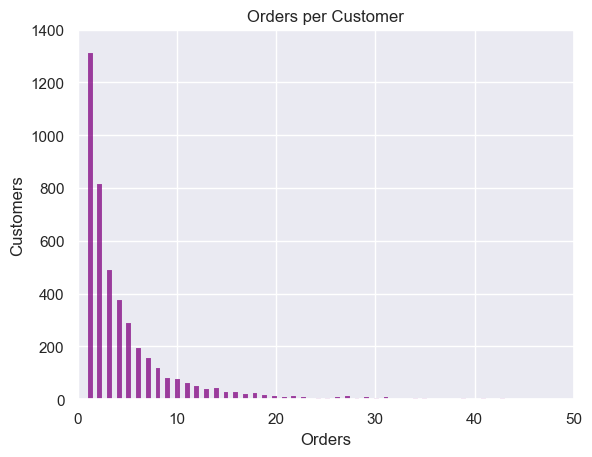

In [272]:
histogram = sns.histplot(orders, kde=False, color='purple')
sns.set_theme(style='darkgrid')
histogram.set(ylim=(0,1400))
histogram.set(xlim=(0,50))
histogram.set(title='Orders per Customer',
       xlabel='Orders', 
       ylabel='Customers');

We can see here that a majority of customers are making less than 10 orders, lets dive a bit deeper into the data now.

The next action in preparation for the cohort analysis will involve removing duplicate records within the fields we will be using for our retention dashboard. 

In [273]:
dropped_data = data[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

Now I will create customer cohorts, seperating by a monthly frequency. 

In [274]:
dropped_data['order_month'] = dropped_data['InvoiceDate'].dt.to_period('M')
dropped_data['cohort'] = dropped_data.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [275]:
df_cohort = dropped_data.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

Finally, I will display the cohorts as a pivot table.

In [276]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot.replace(np.nan, '',regex=True)

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2020-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2021-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,
2021-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,,
2021-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,,,
2021-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,,,,
2021-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,,,,,
2021-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,,,,,,
2021-07,191.0,40.0,39.0,44.0,52.0,22.0,,,,,,,
2021-08,167.0,42.0,42.0,42.0,23.0,,,,,,,,


Here is a simple visualization of our customer cohort, clearly December of 2020 was a great month in terms of customer retention, but the chart does not do an adequate job of visualizing the rest of the months. To better visualize the trends in the data we will need to utilize a heatmap. 

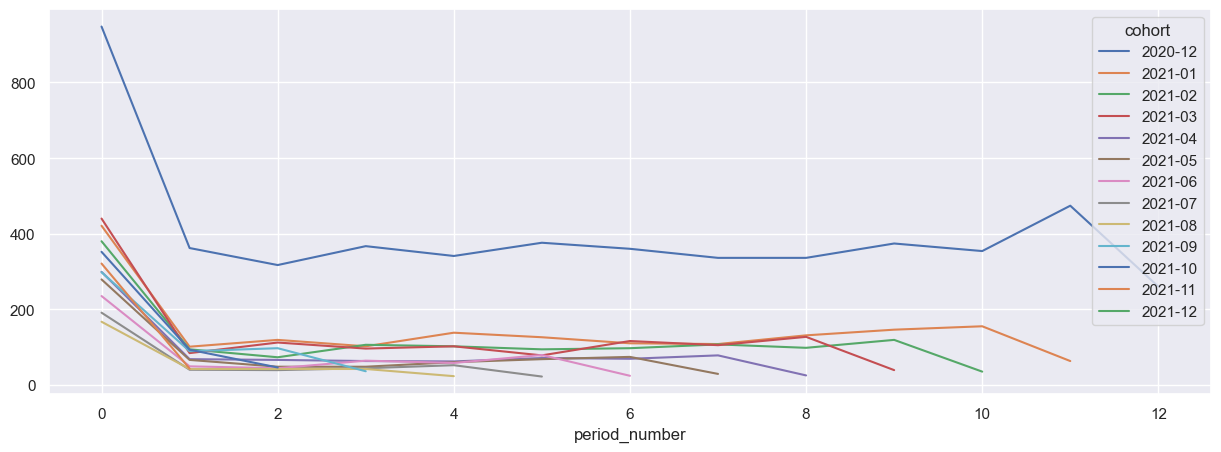

In [277]:
chart = cohort_pivot.transpose()
chart[chart.columns].plot(figsize=(15,5))
sns.set(style='darkgrid')

Building our heatmap to extract some more actionable insights from the dataset. 

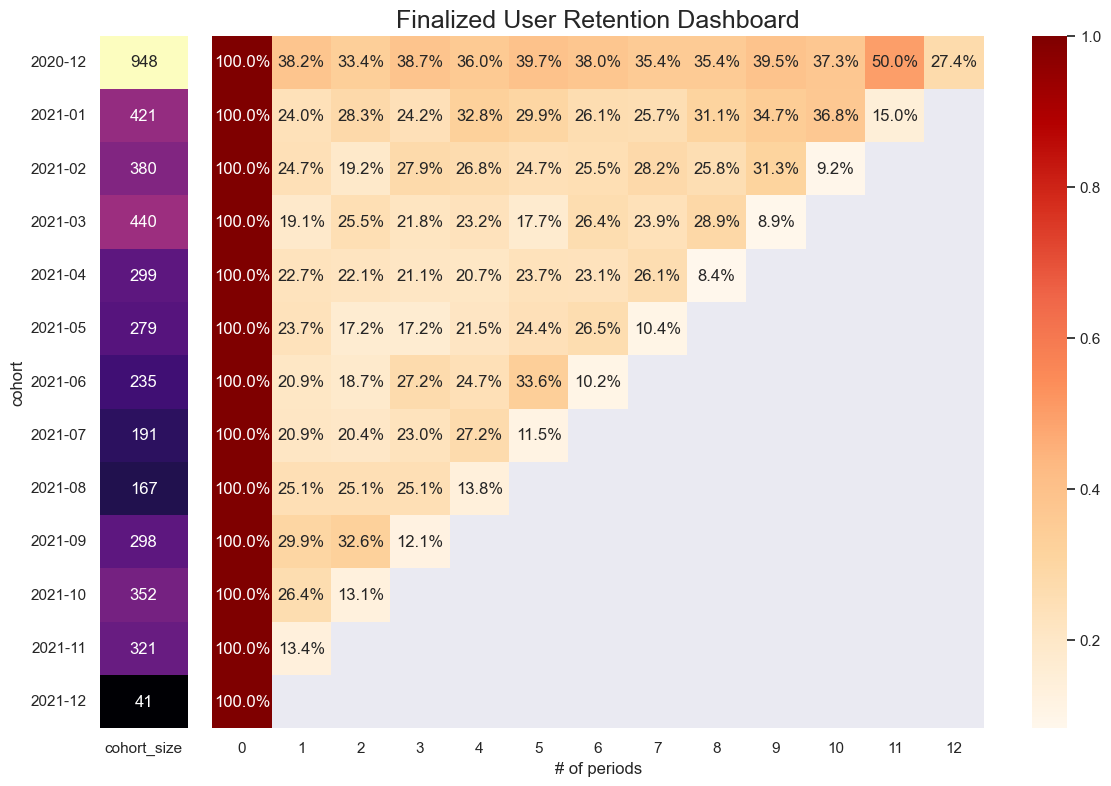

In [279]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.01%', 
                cmap='OrRd', 
                ax=ax[1])
    ax[1].set_title('Finalized User Retention Dashboard', fontsize=18)
    ax[1].set(xlabel='# of periods',
              ylabel='')

   
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g',  
                ax=ax[0],
               cmap='magma')

    fig.tight_layout(pad=1.0)

### Analysis 
Now that we have created a retention dashboard, the data appears to paint a better picture of a customers life cycle across a 12 month period. While simply analyzing some of the data without a matrix would also have been an effective determinate of customer trends such as the most popular products and the average unit price previously discussed, by dividing our customerbase into time dependent segments we can see that we reveal more specific, seasonal trend information that would prove extremely valuable to stakeholders. 

December of 2020 proved to be a standout month where 38% of the 948 person customerbase made purchases the next month, this trend continued for next 12 months with customers obtained during this period being classified as the most likely to be repeat customers. Important questions to consider would be; was there a specific campaign utilized during this period that resulted in customers being more likely to return? Was there a particular use case for a specific product for customers in this segment that resulted in an increased likelihood of their repeat purchase? Or, what was the reason for the sudden increase in retention found during period 11 of December, 2020.

While the first month proved to be succesful, the following months show potential for improved retention. March of 2021 highlights the sharpest drop off in retention from the 440 customers acquired during this period where only 19.1% remained in April. Again the matrix has revealed some valuable insights for us and we can begin to question the drop off during this time by considering whether the customers who made purchases of a specific product in March were less likely to be repeat customers in April, or perhaps if stakeholders had implemented a strategic change during this period that negatively impacted customer retention.

My analysis has simply scratched the surface, but the possibilities of the cohort analysis when correctly implemented into the realm of behavioural analytics are endless!